In [ ]:
import os
import torch
import faiss
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# ========== CONFIG ==========
device = "cuda" if torch.cuda.is_available() else "cpu"
top_k = 5
output_dir = "Output/vectorized_output"

# ========== Load CLIP ==========
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [ ]:
def add_image_to_embedding_db(image_path, output_dir="Output/vectorized_output"):
    import hashlib

    # Load existing filenames and vectors
    vectors_path = os.path.join(output_dir, "vectors.npy") #  NumPy array storing all image embeddings.
    filenames_path = os.path.join(output_dir, "filenames.pkl") #  List of image paths/filenames, keeps track of vector-to-image mapping.

    if not os.path.exists(filenames_path) or not os.path.exists(vectors_path):
        print("[✘] Embedding DB not found.")
        return None

    vectors = np.load(vectors_path)
    with open(filenames_path, "rb") as f:
        filenames = pickle.load(f)

    # Check if image is already embedded
    if image_path in filenames:
        print(f"[✔] Image '{image_path}' is already embedded.")
        index = filenames.index(image_path)
        return vectors[index]  # Return the existing vector

    # If not, embed and add
    print(f"[+] Embedding new image: {image_path}")
    vector = get_image_embedding(image_path)
    vectors = np.vstack([vectors, vector])
    filenames.append(image_path)

    # Save updated files
    np.save(vectors_path, vectors)
    with open(filenames_path, "wb") as f:
        pickle.dump(filenames, f)

    return vector


# ========== Image Embedding ==========
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        features = model.get_image_features(**inputs)
    return features.cpu().numpy()[0]

# ========== Load Saved Vectors & Build FAISS Index ==========
def load_vectors_and_build_index():
    vectors = np.load(os.path.join(output_dir, "vectors.npy"))
    with open(os.path.join(output_dir, "filenames.pkl"), "rb") as f:
        filenames = pickle.load(f)
    index = faiss.IndexFlatL2(vectors.shape[1])
    index.add(vectors)
    return index, filenames

def search_similar_images(index, filenames, query_vector, top_k=5, query_filename=None):
    D, I = index.search(np.array([query_vector]), top_k + 10)  # fetch more in case of skips
    results = []

    # Normalize similarity: smaller distance → higher similarity
    max_distance = np.max(D)

    for idx, i in enumerate(I[0]):
        path = filenames[i]
        dist = float(D[0][idx])

        # Skip if it's the exact same image
        if query_filename and os.path.basename(path) == os.path.basename(query_filename):
            continue

        similarity = 100 - (dist / max_distance) * 100 if max_distance != 0 else 100
        results.append((path, similarity))

        if len(results) == top_k:
            break

    return results


# ========== Display ==========
def show_images(query_path, results):
    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 5))
    axes[0].imshow(Image.open(query_path))
    axes[0].set_title("Query")
    axes[0].axis("off")
    for i, (path, dist) in enumerate(results):
        if os.path.exists(path):
            axes[i + 1].imshow(Image.open(path))
        else:
            axes[i + 1].text(0.5, 0.5, "Not Found", ha="center", va="center")
        axes[i + 1].axis("off")
    plt.tight_layout()
    plt.show()




[✔] Image '2165.jpg' is already embedded.

Finding top 5 similar images ...

Top similar images:
subCategory\Topwear\2136.jpg
subCategory\Topwear\2093.jpg
subCategory\Topwear\2164.jpg
subCategory\Topwear\16526.jpg
subCategory\Topwear\2167.jpg


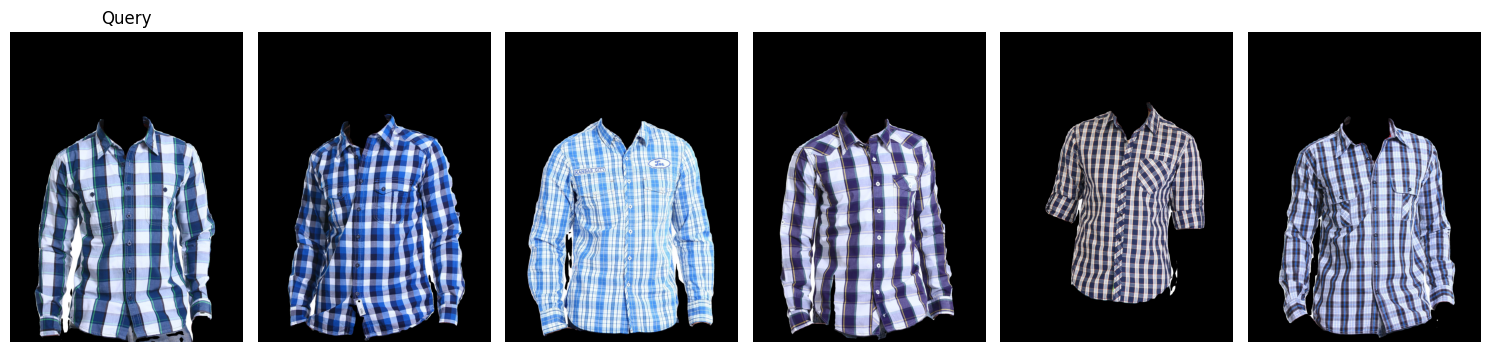

In [ ]:
if __name__ == "__main__":
    query_image_path = "2165.jpg"
    output_dir = "Output/vectorized_output"

    # Step 1: Add if needed, or reuse existing vector
    query_vec = add_image_to_embedding_db(query_image_path, output_dir=output_dir)

    # Step 2: Check if file exists (for display)
    if not os.path.exists(query_image_path):
        raise FileNotFoundError(f"Query image not found: {query_image_path}")

    # Step 3: If it wasn't already embedded, generate vector now
    if query_vec is None:
        print(f"\nVectorizing query image: {query_image_path}")
        query_vec = get_image_embedding(query_image_path)

    # Step 4: Load FAISS index
    index, filenames = load_vectors_and_build_index()

    # Step 5: Search similar images
    print(f"\nFinding top {top_k} similar images ...")
    results = search_similar_images(index, filenames, query_vec, top_k=top_k, query_filename=query_image_path)

    # Step 6: Show results
    print("\nTop similar images:")
    for path, similarity in results:
        print(f"{path}")

    show_images(query_image_path, results)


[+] Embedding new image: 1728.jpg

Finding top 5 similar images ...

Top similar images:
subCategory\Shoes\26533.jpg
subCategory\Shoes\11967.jpg
subCategory\Shoes\13069.jpg
subCategory\Shoes\7710.jpg
subCategory\Shoes\13972.jpg


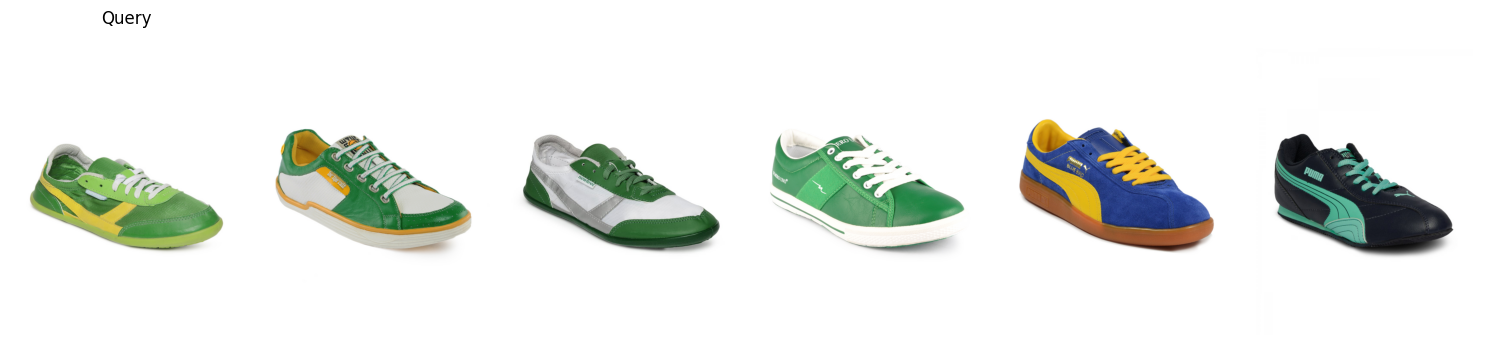

In [ ]:
if __name__ == "__main__":
    query_image_path = "1728.jpg"
    output_dir = "Output/vectorized_output"

    # Step 1: Add if needed, or reuse existing vector
    query_vec = add_image_to_embedding_db(query_image_path, output_dir=output_dir)

    # Step 2: Check if file exists (for display)
    if not os.path.exists(query_image_path):
        raise FileNotFoundError(f"Query image not found: {query_image_path}")

    # Step 3: If it wasn't already embedded, generate vector now
    if query_vec is None:
        print(f"\nVectorizing query image: {query_image_path}")
        query_vec = get_image_embedding(query_image_path)

    # Step 4: Load FAISS index
    index, filenames = load_vectors_and_build_index()

    # Step 5: Search similar images
    print(f"\nFinding top {top_k} similar images ...")
    results = search_similar_images(index, filenames, query_vec, top_k=top_k, query_filename=query_image_path)

    # Step 6: Show results
    print("\nTop similar images:")
    for path, similarity in results:
        print(f"{path}")

    show_images(query_image_path, results)
